# <span style='color:purple'> Imports & settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from pathlib import Path

PENALTY_RATE = 1
POSITION_MAPPING = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

from roster_lib.id_dict import pid2name, name2pid, pid2pos_bref
from roster_lib.preprocessing.loader import Loader
from roster_lib.utils.feature_handler import FeatureHandler
from roster_lib.clustering.clusterer import Clusterer
from roster_lib.constants import PREPROC_DATA_PATH

%reload_ext autoreload
%autoreload 2

Steps worth enriching later on :  
* duplicated entries (entries with most game played was kept, but it was also duplicated)  
* droping player missing is any of the dataset    

# <span style='color:blue'> Loader

### Duplicated handling

In [19]:
loader = Loader()
loader._load_raw_data()
for k,v in loader.raw_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [21]:
issues = []
for k,v in loader.raw_data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [4]:
# for psid in issues :
#     print(pid2name[int(psid.split('_')[0])])
#     for k,v in loader.raw_data.items():
#         if len(v.loc[psid].shape)>1 :
#             print(f"    {k}")

In [5]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [22]:
loader._handle_duplicated()

for k,v in loader.preproc_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [23]:
_tmp_list = []
partly_missing = []
for k,v in loader.preproc_data.items():
    for kk,vv in loader.preproc_data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to       Defense  Misc  Pass  Rebound  Score
from                                        
Defense        0     0     0        0      8
Misc          23     0     0        0     13
Pass          23     0     0        0     13
Rebound       23     0     0        0     13
Score         18     0     0        0      0

### Merging data

In [24]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_time_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in loader.preproc_data.items() ], axis = 1)

_time_df['delta'] = _time_df.max(axis=1) - _time_df.min(axis = 1)
_time_df['name'] = [pid2name[int(x.split('_')[0])] for x in _time_df.index]
_time_df.sort_values('delta', ascending= False).head(10)

Score  Misc  Defense  Pass  Rebound  delta             name
pidSzn                                                                      
202713_2017-18     5.0   5.0      3.3   4.9      3.3    1.7     Kyle Singler
1628451_2017-18    6.7   6.7      8.1   6.7      8.1    1.4      Jacob Wiley
201587_2019-20    23.3  23.3     22.4  23.0     22.4    0.9    Nicolas Batum
1627733_2019-20   18.1  18.1     18.7  17.8     18.7    0.9    Dragan Bender
2199_2016-17      28.0  28.0     27.3  27.6     27.3    0.7   Tyson Chandler
1627761_2017-18   17.7  17.7     18.2  17.5     18.2    0.7   DeAndre Bembry
2030_2014-15       9.6   9.6     10.2   9.5     10.2    0.7    Kenyon Martin
2555_2017-18       5.1   5.1      4.4   5.0      4.4    0.7    Nick Collison
1629627_2019-20   28.2  28.2     27.5  27.8     27.5    0.7  Zion Williamson
1629130_2019-20   30.1  30.1     29.5  29.7     29.5    0.6  Duncan Robinson

In [28]:
loader.df.merge(loader.preproc_data['Score'][['MIN','GP']], left_index=True, right_index=True, how = 'left')

EFG_PCT  TS_PCT  USG_PCT   DD2  TD3  PTS_OFF_TOV  \
pidSzn                                                              
201985_2014-15     0.427   0.451    0.218   0.0  0.0          1.1   
201166_2014-15     0.495   0.534    0.246   1.0  0.0          0.8   
203932_2014-15     0.478   0.517    0.151   1.0  0.0          1.3   
203940_2014-15     0.416   0.443    0.173   3.0  0.0          0.9   
201143_2014-15     0.544   0.563    0.220  14.0  1.0          1.9   
...                  ...     ...      ...   ...  ...          ...   
203897_2019-20     0.526   0.568    0.312   2.0  0.0          4.6   
1629668_2019-20    0.375   0.402    0.147   0.0  0.0          0.0   
1629015_2019-20    0.273   0.313    0.165   0.0  0.0          0.1   
1629627_2019-20    0.592   0.616    0.291   2.0  0.0          3.0   
1629597_2019-20    0.667   0.667    0.103   0.0  0.0          1.0   

                 PTS_2ND_CHANCE  PTS_FB  PTS_PAINT  PTS_PER_ELBOW_TOUCH  ...  \
pidSzn                                                                   ...   
201985_2014-15              0.5     0.2        1.2                0.333  ...   
201166_2014-15              0.6     1.1        4.3                0.464  ...   
203932_2014-15              1.0     1.1        3.2                0.643  ...   
203940_2014-15              1.3     0.2        3.6                0.327  ...   
201143_2014-15              1.8     1.3        8.1                0.405  ...   
...                         ...     ...        ...                  ...  ...   
203897_2019-20              2.2     3.6       10.2                1.070  ...   
1629668_2019-20             0.0     0.6        0.0                0.000  ...   
1629015_2019-20             0.3     0.0        0.9                0.000  ...   
1629627_2019-20             4.3     3.6       17.0                0.829  ...   
1629597_2019-20             1.0     1.5        3.0                0.000  ...   

                 BOX_OUTS  BOX_OUT_PLAYER_TEAM_REBS  BOX_OUT_PLAYER_REBS  \
pidSzn                                                                     
201985_2014-15       0.00                      0.00                 0.00   
201166_2014-15       0.00                      0.00                 0.00   
203932_2014-15       0.00                      0.00                 0.00   
203940_2014-15       0.00                      0.00                 0.00   
201143_2014-15       0.00                      0.00                 0.00   
...                   ...                       ...                  ...   
203897_2019-20       0.87                      0.50                 0.15   
1629668_2019-20      0.00                      0.00                 0.00   
1629015_2019-20      0.14                      0.00                 0.00   
1629627_2019-20      1.17                      0.33                 0.29   
1629597_2019-20      0.75                      0.00                 0.00   

                 PCT_BOX_OUTS_OFF  PCT_BOX_OUTS_DEF  PCT_BOX_OUTS_TEAM_REB  \
pidSzn                                                                       
201985_2014-15              0.000             0.000                  0.000   
201166_2014-15              0.000             0.000                  0.000   
203932_2014-15              0.000             0.000                  0.000   
203940_2014-15              0.000             0.000                  0.000   
201143_2014-15              0.000             0.000                  0.000   
...                           ...               ...                    ...   
203897_2019-20              0.077             0.923                  0.882   
1629668_2019-20             0.000             0.000                  0.000   
1629015_2019-20             0.000             1.000                  0.000   
1629627_2019-20             0.071             0.929                  0.727   
1629597_2019-20             0.667             0.333                  0.000   

                 PCT_BOX_OUTS_REB  position   MIN  GP  
pidSzn            

### Data quality

In [9]:
_dupl_df =  pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in loader.preproc_data.values()], axis = 1)
n_dupl = _dupl_df.index.duplicated().sum()
n_any_na = _dupl_df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [10]:
_dupl_df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [11]:
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A').head(3))
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A').head(3))


FG3A_FREQUENCY  FG3A  FG3_PCT
pidSzn                                       
203945_2014-15             0.0   0.0      NaN
201582_2014-15             0.0   0.0      NaN
1905_2014-15               0.0   0.0      NaN

FG2A_FREQUENCY  FG2A  FG2_PCT
pidSzn                                       
203958_2014-15             0.0   0.0      NaN
203479_2014-15             0.0   0.0      NaN
203925_2015-16             0.0   0.0      NaN

In [12]:
max_time = 0
for pl in partly_missing:
    for v in loader.preproc_data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [13]:

loader.df['position'].value_counts().sort_index()

position
1.0    594
2.0    680
3.0    524
4.0    626
5.0    584
Name: count, dtype: int64

# <span style ='color:chartreuse'>FeatureHandler

In [ ]:
chs_v = sorted([int(f.split("_")[1].split(".")[0][1:]) for f in os.listdir(PREPROC_DATA_PATH / 'clustering') if 'features' in f])
chs_positions = [True, False, True, False, True, True] 
chs_positions = chs_positions+ [True] * (len(chs_v) - len(chs_positions))
for v, pos in zip(chs_v, chs_positions) :
    _ch = FeatureHandler(feature_version= v, use_positions=pos)
    print(len(_ch.incl), 'position' in _ch.incl) 
    

68 True
67 False
29 True
28 False
29 True
68 True
68 True
29 True


In [15]:
# with open("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data/clustering/features_v1.json", "r") as f:
#     data = json.load(f)
# data['incl']

In [ ]:
colinearity_handler = FeatureHandler(use_positions=True)
print(len(colinearity_handler.incl), 'position' in colinearity_handler.incl)

Initial number of features : 31
Top VIF = 380.2 - droping feature TS_PCT
Top VIF = 145.9 - droping feature PTS_PAINT
Top VIF = 116.9 - droping feature EFG_PCT
Top VIF = 82.1 - droping feature FG2A
Top VIF = 45.3 - droping feature FG2_PCT
Top VIF = 41.7 - droping feature USG_PCT
Top VIF = 34.5 - droping feature FG3A
Top VIF = 23.1 - droping feature PTS_OFF_TOV
Top VIF = 22.9 - droping feature PAINT_TOUCH_FG_PCT
Top VIF = 19.8 - droping feature CATCH_SHOOT_FG_PCT
Top VIF = 18.6 - droping feature PTS_2ND_CHANCE
Top VIF = 17.5 - droping feature PTS_PER_TOUCH
Top VIF = 13.0 - droping feature FG2A_FREQUENCY
Top VIF = 9.7 - stopping features exclusion with 18 feature retained
Initial number of features : 12
Top VIF = 96157.8 - droping feature DIST_MILES
Top VIF = 295.0 - droping feature DIST_MILES_OFF
Top VIF = 289.7 - droping feature AVG_SPEED
Top VIF = 141.4 - droping feature AVG_SPEED_DEF
Top VIF = 14.0 - droping feature DIST_MILES_DEF
Top VIF = 6.9 - stopping features exclusion with 7 fea

In [28]:
colinearity_handler.get_data('autoexcl', False)

{'Score':                   DD2  TD3  PTS_FB  PTS_PER_ELBOW_TOUCH  PTS_PER_POST_TOUCH  \
 pidSzn                                                                        
 201985_2014-15    0.0  0.0     0.2                0.333               3.000   
 201166_2014-15    1.0  0.0     1.1                0.464               0.000   
 203932_2014-15    1.0  0.0     1.1                0.643               0.400   
 203940_2014-15    3.0  0.0     0.2                0.327               0.344   
 201143_2014-15   14.0  1.0     1.3                0.405               0.457   
 ...               ...  ...     ...                  ...                 ...   
 203897_2019-20    2.0  0.0     3.6                1.070               0.450   
 1629668_2019-20   0.0  0.0     0.6                0.000               0.000   
 1629015_2019-20   0.0  0.0     0.0                0.000               0.000   
 1629627_2019-20   2.0  0.0     3.6                0.829               0.503   
 1629597_2019-20   0.0  0.0    

In [ ]:
colinearity_handler.compute_vifs()
for k,v in colinearity_handler.vifs.items():
    print(f"Feature Selection : {k}")
    display(v.round(2).head(5))

# <span style ='color:orange'> Clusterer

### <span style = 'color:chartreuse'> Results

<sopan style = 'color:cyan'>Findings and comments : </span>
* From various attemps before `v1`, Centers and Power Forwards are more separated, whereas PG, SG and SF are grouped together 
* `v1` uses listed positions
* `v2` does not
* `v3` uses a considerably reduced MANUAL_INCLUSION of features, with listed positions (`v4` without)
* `v5` introduces `n_runs` (5 repeats, same parameters than `v4`)
* <span style = 'color : red'> Attention </span> possible errors in `position` inclusion in version 1 to 5, may be missing for `incl` scenarios
* `v6` uses `v1` features with `n_runs = 5`, set `evrs` from 0.6 and `n_clust` up to 20. Re-introduction of `agg_single`
* `v7` introduces `SilhouetteW` and `ball_hall` score with `n_clust` up to 16
* `v8` run is similar to `v7` but considers `v3` features
* `v9` introduces `SphericalClustering` and `SpectralClustering` (implemented but not used) and runs on `v3` features over a reduced hyperparameter space, and 1 run
* `v10` run is similar to `v9` but considers `v1` features, and only for `incl` features
* `v11` exclude positions and runs on reduced `incl` features 
* `v12` exclude positions and `robust` scaler, as its visual inspection seems not to fit data. `incl` feature are from v1 
* `v13` introduces `MIN` and `GP`, runs on `v3` features  and reintroduces `robust_scaler`


In [2]:
clusterer = Clusterer(alpha= 0.5, beta = 0.5, use_positions=False)
clusterer.last_version

13

In [3]:
cdf = clusterer.rdf.copy()
# cdf = clusterer.load_results(7)
display(cdf.sort_values(by = 'silhouette', ascending=False).head(5))


feature_selection        method scaling  evr  n_PC  n_clust  silhouette  \
319              incl  agg_complete  robust  0.6     2        2    0.899071   
308              incl   agg_average  robust  0.6     2        2    0.899071   
363              incl   agg_average  robust  0.8     5        2    0.873170   
374              incl  agg_complete  robust  0.8     5        2    0.873170   
429              incl  agg_complete  robust  0.9     9        2    0.860390   

     silhouetteW  davies_bouldin  calinski_harabasz   ball_hall   entropy  \
319     0.842082        0.205048         464.069448  105.568604  0.014623   
308     0.842082        0.205048         464.069448  105.568604  0.014623   
363     0.820959        0.230328         358.433412  123.490605  0.014623   
374     0.820959        0.230328         358.433412  123.490605  0.014623   
429     0.812027        0.242377         315.465660  132.100202  0.014623   

     e_w_silhouette  evr_e_w_silhouette  
319        0.108720            0.084214  
308        0.108720            0.084214  
363        0.105588            0.094441  
374        0.105588            0.094441  
429        0.104042            0.098703

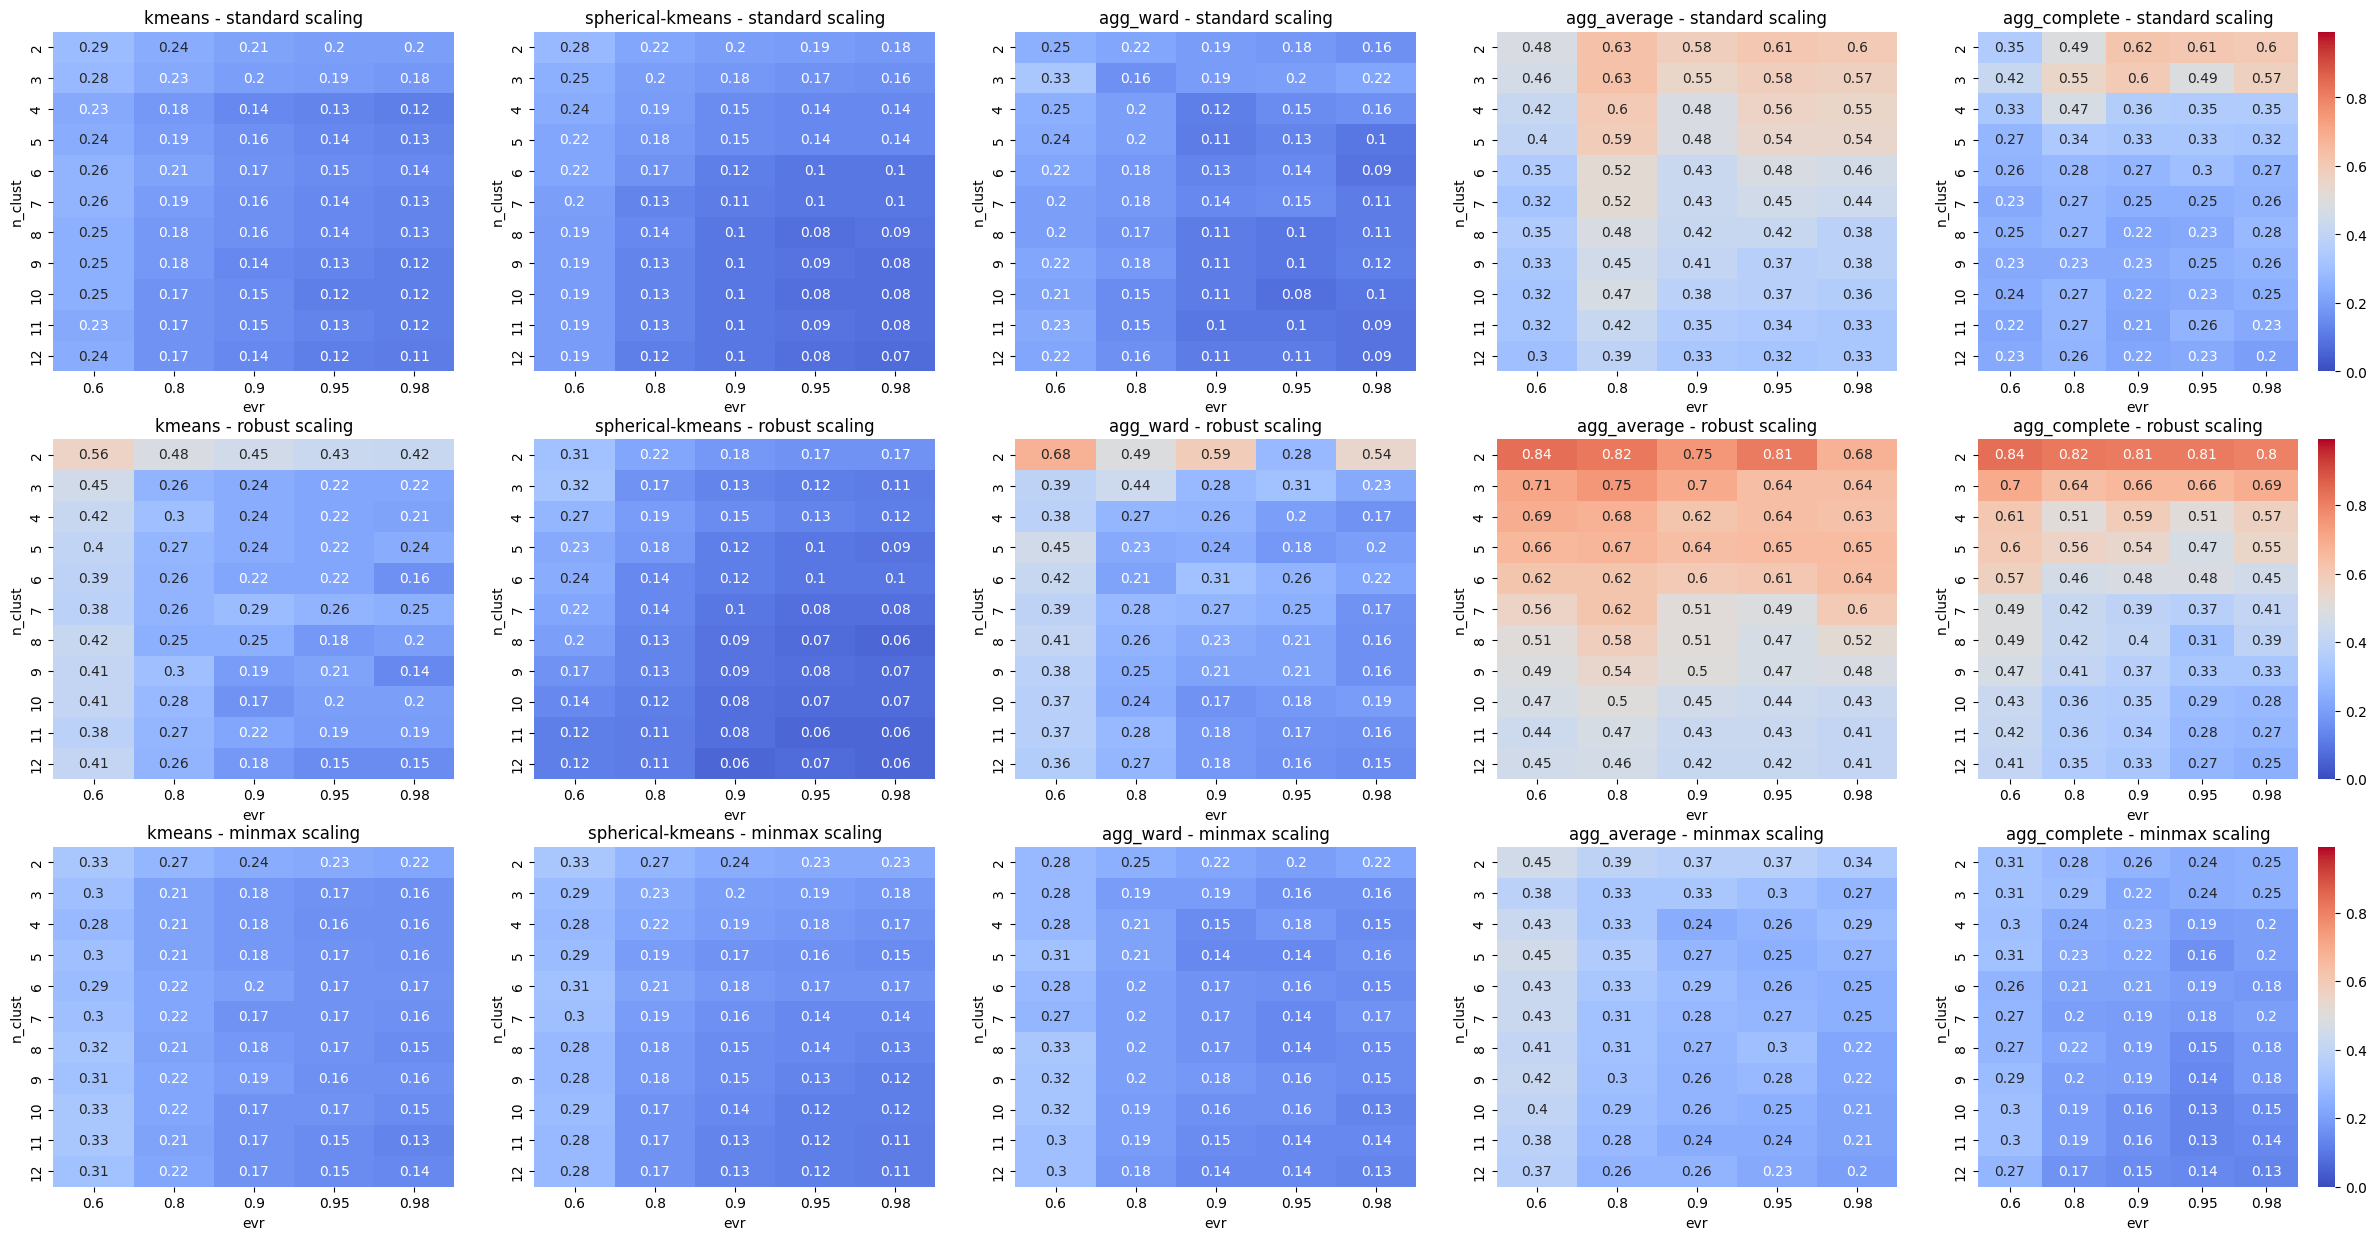

In [4]:
scalings = cdf['scaling'].unique()
methods = cdf['method'].unique()

# metric = 'silhouette'
metric = 'silhouetteW'
# metric = 'e_w_silhouette'
# metric = 'evr_e_w_silhouette'

heatmap_kw = {'cmap': 'coolwarm', 'vmin': max(cdf[metric].min()-0.15,0), 'vmax':cdf[metric].max()+0.15, 'annot': True}
fig, axs = plt.subplots(len(scalings),len(methods),figsize = (6*len(methods),5* len(scalings)));
_cdf = cdf.groupby(['method','scaling','evr','n_clust']).agg({'n_PC':'first', metric:'max'}).reset_index()
for i, ax in enumerate(axs.flatten()) :
    method = methods[i % len(methods)]
    scaling = scalings[i // len(methods)]
    sns.heatmap(data= _cdf[(_cdf['method']==method)&(_cdf['scaling']==scaling)].pivot(index = 'n_clust', columns = ['evr'], values = metric).round(2), 
                ax = ax, **heatmap_kw, cbar = (i % len(methods)) == len(methods) -1);
    ax.set_title(f"{method} - {scaling} scaling");


Silhouette: 0.671 | SilhouetteW: 0.602 | Davies-Bouldin: 0.380 | Calinski-Harabasz: 176.599 | Ball-Hall: 111.154 | Normalized Entropy : 0.032


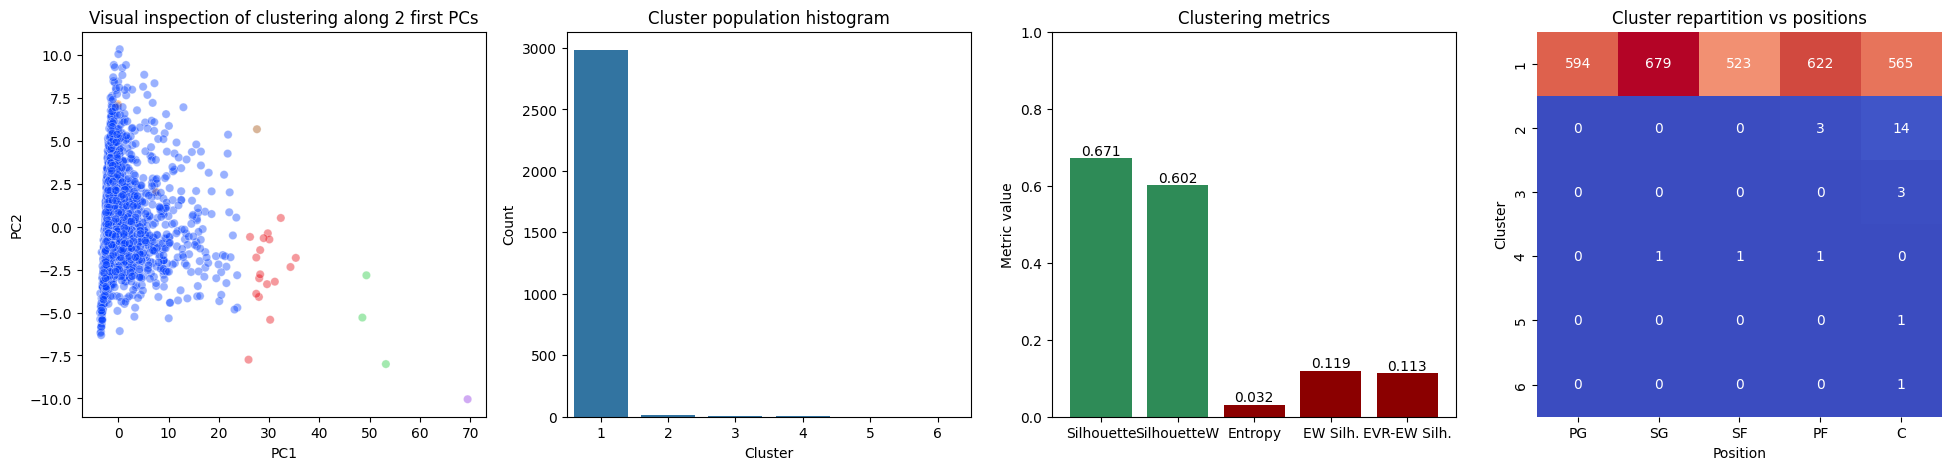

In [6]:
clusterer.plot_clustering(evr= 0.9, n_clust=6, method = 'agg_average', scaling='robust', feature_selection='incl')

### <span style = 'color:yellow'>Metrics

#### Display data 

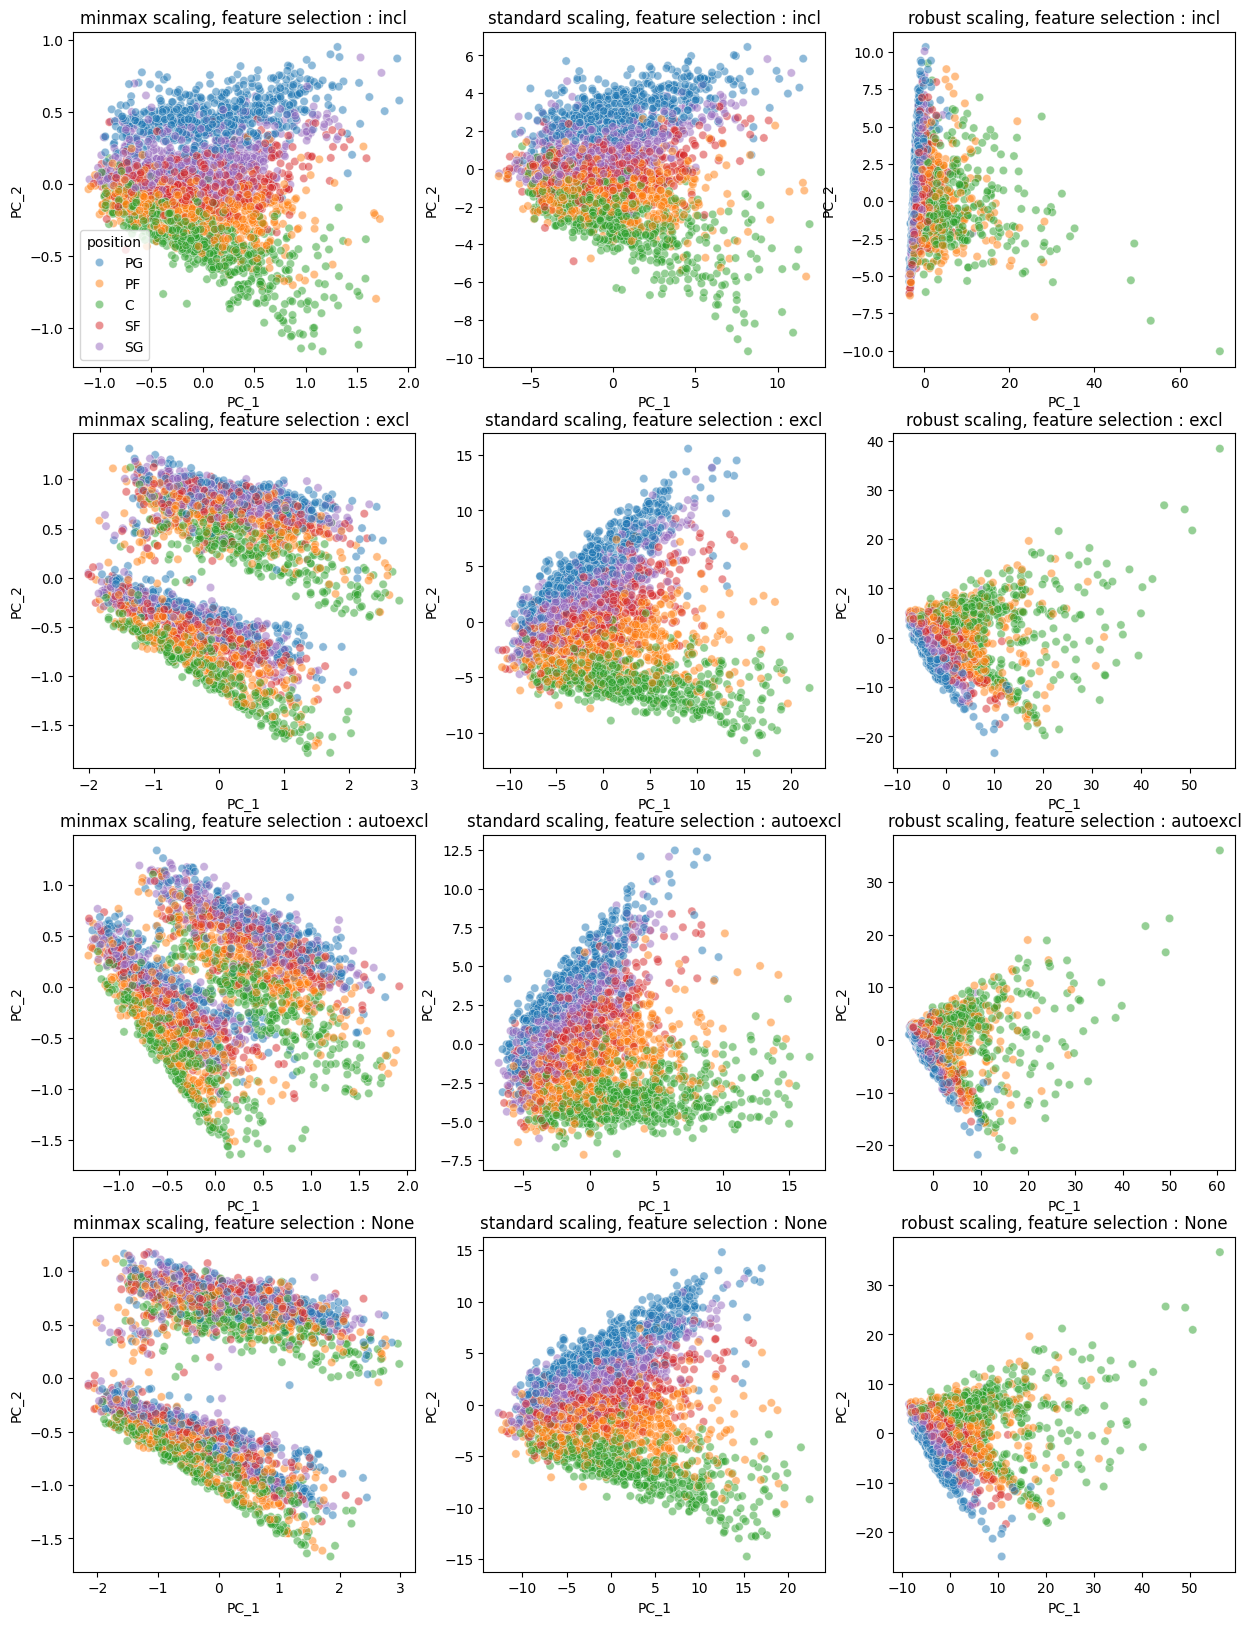

In [7]:
clusterer.plot_data()

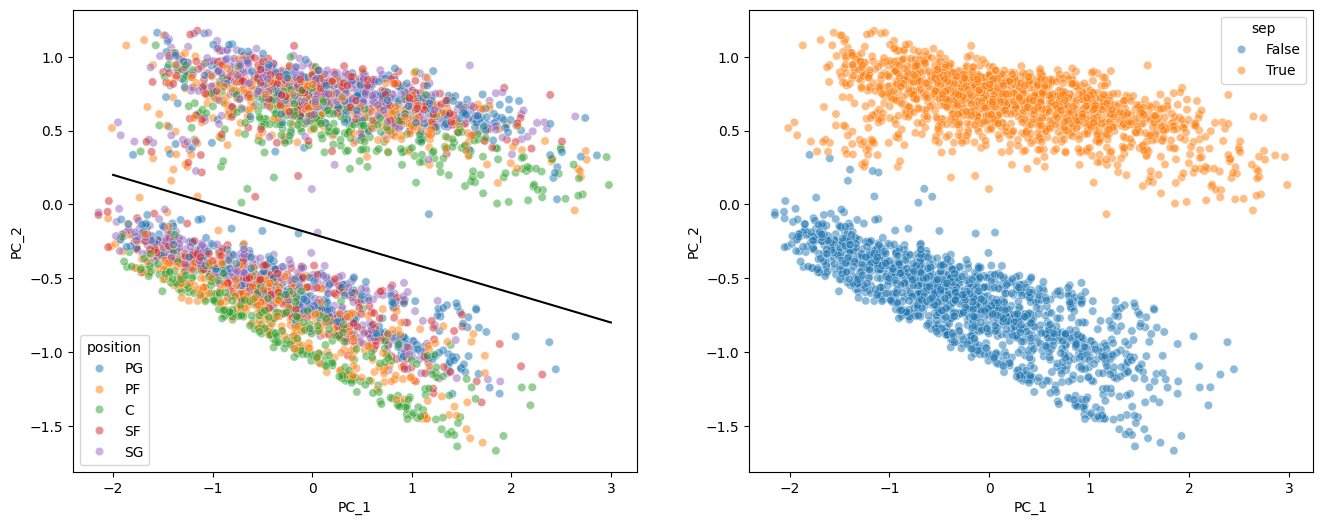

In [ ]:
_df = clusterer.get_data(scaling='minmax', feature_selection= None, perform_PCA= True)
_df = _df[['PC_1','PC_2','position']]
fig, axs = plt.subplots(1,2,figsize = (16,6))
sns.scatterplot(data = _df, x = 'PC_1', y = 'PC_2', hue = 'position', alpha = 0.5, ax = axs[0]);
x0,y0 = -2, 0.2
x1, y1 = 3, -0.8
axs[0].plot([x0,x1],[y0,y1], c = 'black');
_df['sep'] = _df['PC_2'] +0.2 * _df['PC_1'] > 0
sns.scatterplot(data = _df, x = 'PC_1', y = 'PC_2', hue = 'sep', alpha = 0.5, ax = axs[1]);


In [32]:
W, pca = clusterer.get_ACP_matrix(scaling='minmax', return_PCA=True, feature_selection='incl')
W

PC_1      PC_2      PC_3      PC_4      PC_5  \
MIN                        0.377651  0.022795  0.120223  0.017370  0.227680   
GP                         0.394311 -0.121845  0.515192  0.604740 -0.282211   
EFG_PCT                    0.037210 -0.050786  0.006375  0.049675 -0.015337   
USG_PCT                    0.122965  0.081959  0.017543 -0.225198  0.147533   
PTS_2ND_CHANCE             0.200855 -0.214262  0.026638 -0.187722  0.054087   
PTS_PAINT                  0.257760 -0.110849 -0.010389 -0.256254 -0.043635   
DRIVE_PTS                  0.182055  0.215145 -0.011272 -0.117514  0.089985   
FG2A                       0.285417 -0.016656  0.053453 -0.281105  0.070694   
FG2_PCT                    0.047259 -0.119953  0.022992  0.015529 -0.124458   
FG3A                       0.153693  0.177555 -0.001718  0.169516  0.452293   
FG3_PCT                    0.074154  0.157371  0.043188  0.228269  0.326725   
OFF_LOOSE_BALLS_RECOVERED  0.193990 -0.002956 -0.492290  0.155271 -0.050044   
DEF_LOOSE_BALLS_RECOVERED  0.161473  0.059272 -0.419999  0.214460  0.015036   
PFD                        0.236175 -0.004855  0.018976 -0.220506  0.061513   
STL                        0.249546  0.123232  0.018773  0.008526  0.119888   
BLK                        0.097867 -0.191860  0.001958 -0.090780 -0.047773   
PCT_PLUSMINUS             -0.015380  0.018769 -0.008874 -0.007435  0.007516   
DEFLECTIONS                0.218336  0.080274 -0.367378  0.209658  0.084364   
CHARGES_DRAWN              0.027691  0.009957 -0.070946  0.032585  0.013477   
SCREEN_ASSISTS             0.077044 -0.222737 -0.167488 -0.025943 -0.236654   
TIME_OF_POSS               0.222391  0.324782  0.041894 -0.163235 -0.156961   
AVG_DRIB_PER_TOUCH         0.078752  0.488524  0.008950 -0.125195 -0.308919   
AST_PCT                    0.099796  0.274507 -0.007896 -0.133126 -0.291682   
AST_TO                     0.043614  0.176467 -0.004669  0.086057 -0.217415   
AST_RATIO                  0.032478  0.182884 -0.016248  0.023223 -0.310952   
OREB_UNCONTEST             0.171498 -0.211959 -0.002549 -0.110906 -0.130195   
DREB_CONTEST               0.161756 -0.307338  0.039427 -0.168198 -0.038874   
DREB_UNCONTEST             0.228407 -0.123466 -0.003456 -0.087113  0.038812   
OFF_BOXOUTS                0.029459 -0.083019 -0.087766  0.004326 -0.096620   
DEF_BOXOUTS                0.097541 -0.205543 -0.338410  0.130445 -0.191953   

                               PC_6      PC_7      PC_8      PC_9     PC_10  \
MIN                        0.089339  0.142957 -0.232633  0.001321 -0.256124   
GP                        -0.131679 -0.238642  0.063782 -0.129024  0.110018   
EFG_PCT                   -0.036316  0.090975  0.187057  0.320679 -0.082531   
USG_PCT                   -0.258384 -0.125702  0.256533 -0.136768  0.077929   
PTS_2ND_CHANCE            -0.044132  0.051209 -0.006903  0.070340  0.109444   
PTS_PAINT                 -0.069030 -0.131841  0.118696  0.132674  0.124459   
DRIVE_PTS                 -0.126230 -0.215300  0.132002  0.034781 -0.059885   
FG2A                      -0.120234 -0.116437  0.028429 -0.026754  0.163722   
FG2_PCT                    0.035925 -0.069683  0.411823  0.648021 -0.422549   
FG3A                      -0.130443  0.107692 -0.008587 -0.134931 -0.412761   
FG3_PCT                   -0.253611  0.578710  0.175147  0.273923  0.452769   
OFF_LOOSE_BALLS_RECOVERED -0.267189 -0.205295 -0.236833  0.187552  0.136936   
DEF_LOOSE_BALLS_RECOVERED -0.058717 -0.215460 -0.249049  0.178226  0.062279   
PFD                       -0.074507 -0.022014  0.087940 -0.083614 -0.075666   
STL                        0.471736  0.050005 -0.187992  0.037145 -0.141989   
BLK                        0.103343  0.081666 -0.008425  0.025665  0.092854   
PCT_PLUSMINUS             -0.017705 -0.015383 -0.006073 -0.026717  0.023414   
DEFLECTIONS                0.550411 -0.074005  0.483254 -0.188505  0.225536   
CHARGES_DRAWN              0.038740  0.038809  0.080664 -0.068171 -0.057810   
S

In [33]:
pc = 1
top_k = 10
display(W[[f"PC_{pc}"]].sort_values(f"PC_{pc}",ascending=False)[:top_k])
display(W[[f"PC_{pc}"]].sort_values(f"PC_{pc}",ascending=True)[:top_k])

PC_1
GP              0.394311
MIN             0.377651
FG2A            0.285417
PTS_PAINT       0.257760
STL             0.249546
PFD             0.236175
DREB_UNCONTEST  0.228407
TIME_OF_POSS    0.222391
DEFLECTIONS     0.218336
PTS_2ND_CHANCE  0.200855

PC_1
PCT_PLUSMINUS      -0.015380
CHARGES_DRAWN       0.027691
OFF_BOXOUTS         0.029459
AST_RATIO           0.032478
EFG_PCT             0.037210
AST_TO              0.043614
FG2_PCT             0.047259
FG3_PCT             0.074154
SCREEN_ASSISTS      0.077044
AVG_DRIB_PER_TOUCH  0.078752

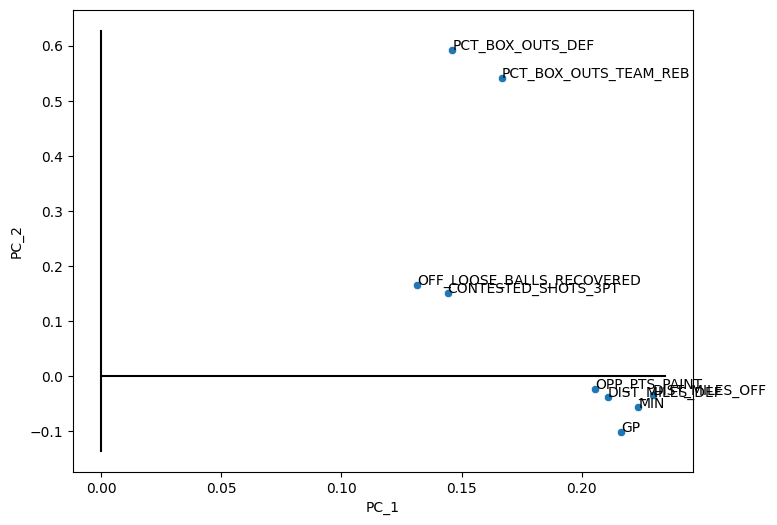

In [40]:
clusterer.plot_PCA(n_features= 8,scaling='minmax',feature_selection='excl')

In [24]:
_df.pivot_table(index = 'position', columns = 'sep', values = 'PC_1', aggfunc= 'count')

sep       False  True 
position              
C           283    301
PF          322    304
PG          307    287
SF          274    250
SG          325    355

In [35]:
_df[_df['position'] == 'SF'].sort_values('PC_2').head(15)

PC_1      PC_2 position    sep
LeBron James_2015-16           1.700759 -1.341311       SF  False
Carmelo Anthony_2014-15        1.218015 -1.279218       SF  False
Carmelo Anthony_2015-16        1.214681 -1.248151       SF  False
Andrew Wiggins_2014-15         1.040189 -1.199234       SF  False
LeBron James_2014-15           1.652461 -1.198065       SF  False
LeBron James_2016-17           2.310225 -1.152448       SF  False
Rudy Gay_2014-15               1.134230 -1.143779       SF  False
Kevin Durant_2015-16           1.388463 -1.135895       SF  False
Rudy Gay_2015-16               0.926058 -1.114812       SF  False
Andrew Wiggins_2015-16         0.996007 -1.104218       SF  False
Paul George_2015-16            1.321437 -1.101363       SF  False
Giannis Antetokounmpo_2016-17  2.097011 -1.096474       SF  False
Dahntay Jones_2015-16          0.921365 -1.095361       SF  False
Kawhi Leonard_2014-15          0.848105 -1.047538       SF  False
Kawhi Leonard_2015-16          0.951357 -1.046826       SF  False

##### Robust Scaler analysis 

In [6]:
for fs, thres in zip(['incl','excl','autoexcl'], [40,40, 36]):
    _sdf = clusterer.get_scaled_data(scaling='robust', feature_selection=fs)
    display(_sdf[_sdf['PC_1'] > thres])

PC_1      PC_2       PC_3      PC_4      PC_5  \
Andre Drummond_2017-18  49.311270 -2.439335  -4.716864 -5.912972 -1.988867   
DeAndre Jordan_2017-18  48.525156 -4.932666  -5.194094 -5.431028  0.454382   
Enes Kanter_2017-18     53.201606 -7.420678  -9.073248 -6.919385  0.586022   
Steven Adams_2017-18    69.425966 -9.340360 -11.203402 -8.197198  1.222020   

                            PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
Andre Drummond_2017-18 -0.762189 -2.684410 -2.884165  3.422559  0.403830  ...   
DeAndre Jordan_2017-18 -0.998317 -3.692359 -3.483101  2.878046 -0.442690  ...   
Enes Kanter_2017-18    -0.412983 -6.201624 -4.190781  2.190373 -1.359517  ...   
Steven Adams_2017-18   -1.943977 -5.932951 -4.785808  2.884499 -1.073858  ...   

                           PC_20     PC_21     PC_22     PC_23     PC_24  \
Andre Drummond_2017-18 -0.539918 -0.339861  0.628332 -0.015162  0.950448   
DeAndre Jordan_2017-18 -1.038938  0.086020  0.657494 -0.507777 -0.492173   
Enes Kanter_2017-18    -0.340660 -1.105004 -0.289530 -0.248695  0.087861   
Steven Adams_2017-18    0.700677  0.330349 -0.137801 -0.039249  0.814879   

                           PC_25     PC_26     PC_27     PC_28     PC_29  
Andre Drummond_2017-18 -0.146067 -0.379790 -0.040100 -0.376790  0.059275  
DeAndre Jordan_2017-18 -0.789298 -0.526530  0.049833  0.131104  0.022823  
Enes Kanter_2017-18    -0.240036  0.040856  0.052627  0.127173 -0.066851  
Steven Adams_2017-18    0.134170  0.732643  0.130714  0.220777  0.233088  

[4 rows x 29 columns]

PC_1       PC_2       PC_3       PC_4       PC_5  \
Andre Drummond_2017-18  50.527884  21.440004  16.219764   6.012722   9.702180   
DeAndre Jordan_2017-18  44.799460  26.635545  17.452568   4.540911   8.713214   
Dwight Howard_2017-18   42.371370  11.587099   6.824589   9.791593   2.553499   
Enes Kanter_2017-18     49.029823  25.676962  15.614283  13.580379   1.050057   
Steven Adams_2017-18    56.231422  38.057169  22.846221   7.741419   4.516426   
Andre Drummond_2018-19  40.296603   9.990925   8.474000   1.917903  10.226069   

                             PC_6      PC_7       PC_8      PC_9     PC_10  \
Andre Drummond_2017-18  -7.888475 -0.744184  -3.165931  1.092535  0.776924   
DeAndre Jordan_2017-18  -8.701607 -1.656278  -3.629721  1.455321  2.462922   
Dwight Howard_2017-18   -6.897755 -0.194769   0.595807  2.297953 -0.563341   
Enes Kanter_2017-18    -10.935294 -0.996837  -7.314732  1.725845  0.747870   
Steven Adams_2017-18   -11.275454 -3.451263 -13.900343 -2.256861  2.470303   
Andre Drummond_2018-19  -8.237436  0.969754   2.444964  2.230723  1.608030   

                        ...    PC_107    PC_108    PC_109    PC_110    PC_111  \
Andre Drummond_2017-18  ...  0.093789 -0.109424  0.055677  0.061061  0.165586   
DeAndre Jordan_2017-18  ... -0.111711  0.015935 -0.005339  0.036933 -0.034257   
Dwight Howard_2017-18   ... -0.159031 -0.003521  0.093581  0.004385 -0.063372   
Enes Kanter_2017-18     ... -0.096898 -0.013728  0.068345  0.006337 -0.127944   
Steven Adams_2017-18    ... -0.197948  0.058261 -0.089383  0.077230  0.094387   
Andre Drummond_2018-19  ...  0.035529 -0.008115  0.041811  0.021668  0.287494   

                          PC_112    PC_113    PC_114    PC_115    PC_116  
Andre Drummond_2017-18  0.075163 -0.083360  0.090748 -0.040577  0.000029  
DeAndre Jordan_2017-18  0.071661 -0.007229  0.024727  0.002671  0.000041  
Dwight Howard_2017-18  -0.013775  0.121244 -0.096727  0.044873  0.000028  
Enes Kanter_2017-18    -0.023988 -0.112909  0.035884  0.047787  0.000008  
Steven Adams_2017-18    0.065578  0.084899  0.000400 -0.081692  0.000045  
Andre Drummond_2018-19  0.038822 -0.014717 -0.035146  0.049447  0.000030  

[6 rows x 116 columns]

PC_1       PC_2       PC_3       PC_4       PC_5  \
Andre Drummond_2017-18  49.117337  16.473196   8.587943  10.216517   5.164782   
DeAndre Jordan_2017-18  44.876854  21.501134   7.885632  10.054705   4.447787   
Dwight Howard_2017-18   39.829421   6.258073   2.269205   3.410160   8.549131   
Enes Kanter_2017-18     49.982426  22.861027   7.228382   3.901735  12.896140   
Steven Adams_2017-18    60.630849  35.850287  10.760360   6.319371   9.643737   
Andre Drummond_2018-19  38.513743   4.013038   3.906439   9.958183   1.444981   

                            PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
Andre Drummond_2017-18  0.044162  0.107946 -0.790190  1.956643 -3.589169  ...   
DeAndre Jordan_2017-18 -1.559445  2.160126  1.178171  2.000163 -3.171379  ...   
Dwight Howard_2017-18   1.284281  0.155372  1.655765  1.123639 -2.213004  ...   
Enes Kanter_2017-18    -1.138535  1.667950  0.920425  2.359958 -3.790944  ...   
Steven Adams_2017-18   -4.168331  1.790199 -4.008945  4.110625 -5.842806  ...   
Andre Drummond_2018-19  0.583650 -0.983304  1.414390  1.919419 -1.539772  ...   

                           PC_63     PC_64     PC_65     PC_66     PC_67  \
Andre Drummond_2017-18  0.090636 -0.707221  0.042821  0.151370 -0.388948   
DeAndre Jordan_2017-18 -0.249346 -0.016034 -0.667153 -0.155662 -0.501871   
Dwight Howard_2017-18   0.000619  0.236369 -0.122153  0.037256 -0.787747   
Enes Kanter_2017-18     0.040911 -0.402679 -0.313203  0.291803 -0.084106   
Steven Adams_2017-18   -0.108950  0.329981 -0.152365  0.010339 -0.226072   
Andre Drummond_2018-19 -0.028816 -0.417980 -0.142749  0.565907  0.227368   

                           PC_68     PC_69     PC_70     PC_71     PC_72  
Andre Drummond_2017-18  0.114848  0.322071 -0.236436 -0.349192 -0.258051  
DeAndre Jordan_2017-18 -0.033893  0.051399  0.066792  0.102618  0.053140  
Dwight Howard_2017-18  -0.252656  0.095806  0.261451  0.153188 -0.084088  
Enes Kanter_2017-18     0.420560  0.309090 -0.093397 -0.285264  0.006881  
Steven Adams_2017-18    0.774826  0.465617  0.129010  0.201380 -0.196742  
Andre Drummond_2018-19  0.177109  0.235094 -0.164291 -0.060336 -0.259562  

[6 rows x 72 columns]

#### Highest score per metric

In [ ]:
target_n_clust = 6 # Set to 2 to ignore
target_evr = 0.6 # Set to 0.4 to ignore
top_k = 10
ref_metric = 'e_w_silhouette'

top_clusterings = {}
for k,v in clusterer.metrics.items():
    _tdf = cdf[(cdf['n_clust']>= target_n_clust) & (cdf['evr']>= target_evr)].sort_values(by = k, ascending= v['ascending']).head(top_k).reset_index(drop=True)
    best_index = _tdf.sort_values(by = ref_metric, ascending=False).index[0]
    params = []
    for index,row in _tdf.iterrows():
        params.append({'feature_selection': row['feature_selection'], 'method': row['method'], 'scaling':row['scaling'], 'evr':row['evr'], 'n_clust':row['n_clust']})
    top_clusterings[k] = {'best_index':best_index, 'n_PC':_tdf.loc[best_index,'n_PC'], 'params' : params}
    item = top_clusterings[k]['params'][top_clusterings[k]['best_index']]
    print(f"n_PC : {top_clusterings[k]['n_PC']:>2}, Exp Characteristics : {item}")   

n_PC : 37, Exp Characteristics : {'feature_selection': 'autoexcl', 'method': 'agg_average', 'scaling': 'standard', 'evr': 0.9, 'n_clust': 6}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'agg_average', 'scaling': 'minmax', 'evr': 0.6, 'n_clust': 6}
n_PC : 54, Exp Characteristics : {'feature_selection': 'excl', 'method': 'agg_average', 'scaling': 'standard', 'evr': 0.95, 'n_clust': 7}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.6, 'n_clust': 6}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.6, 'n_clust': 6}


Silhouette: 0.404 | SilhouetteW: 0.375 | Davies-Bouldin: 0.834 | Calinski-Harabasz: 21.079 | Ball-Hall: 308.259 | Normalized Entropy : 0.028
Silhouette: 0.312 | SilhouetteW: 0.397 | Davies-Bouldin: 0.877 | Calinski-Harabasz: 479.672 | Ball-Hall: 1.061 | Normalized Entropy : 0.399
Silhouette: 0.362 | SilhouetteW: 0.387 | Davies-Bouldin: 0.626 | Calinski-Harabasz: 15.276 | Ball-Hall: 288.769 | Normalized Entropy : 0.026
Silhouette: 0.325 | SilhouetteW: 0.297 | Davies-Bouldin: 0.962 | Calinski-Harabasz: 1384.546 | Ball-Hall: 0.947 | Normalized Entropy : 0.914
Silhouette: 0.325 | SilhouetteW: 0.299 | Davies-Bouldin: 0.959 | Calinski-Harabasz: 1385.358 | Ball-Hall: 0.934 | Normalized Entropy : 0.912


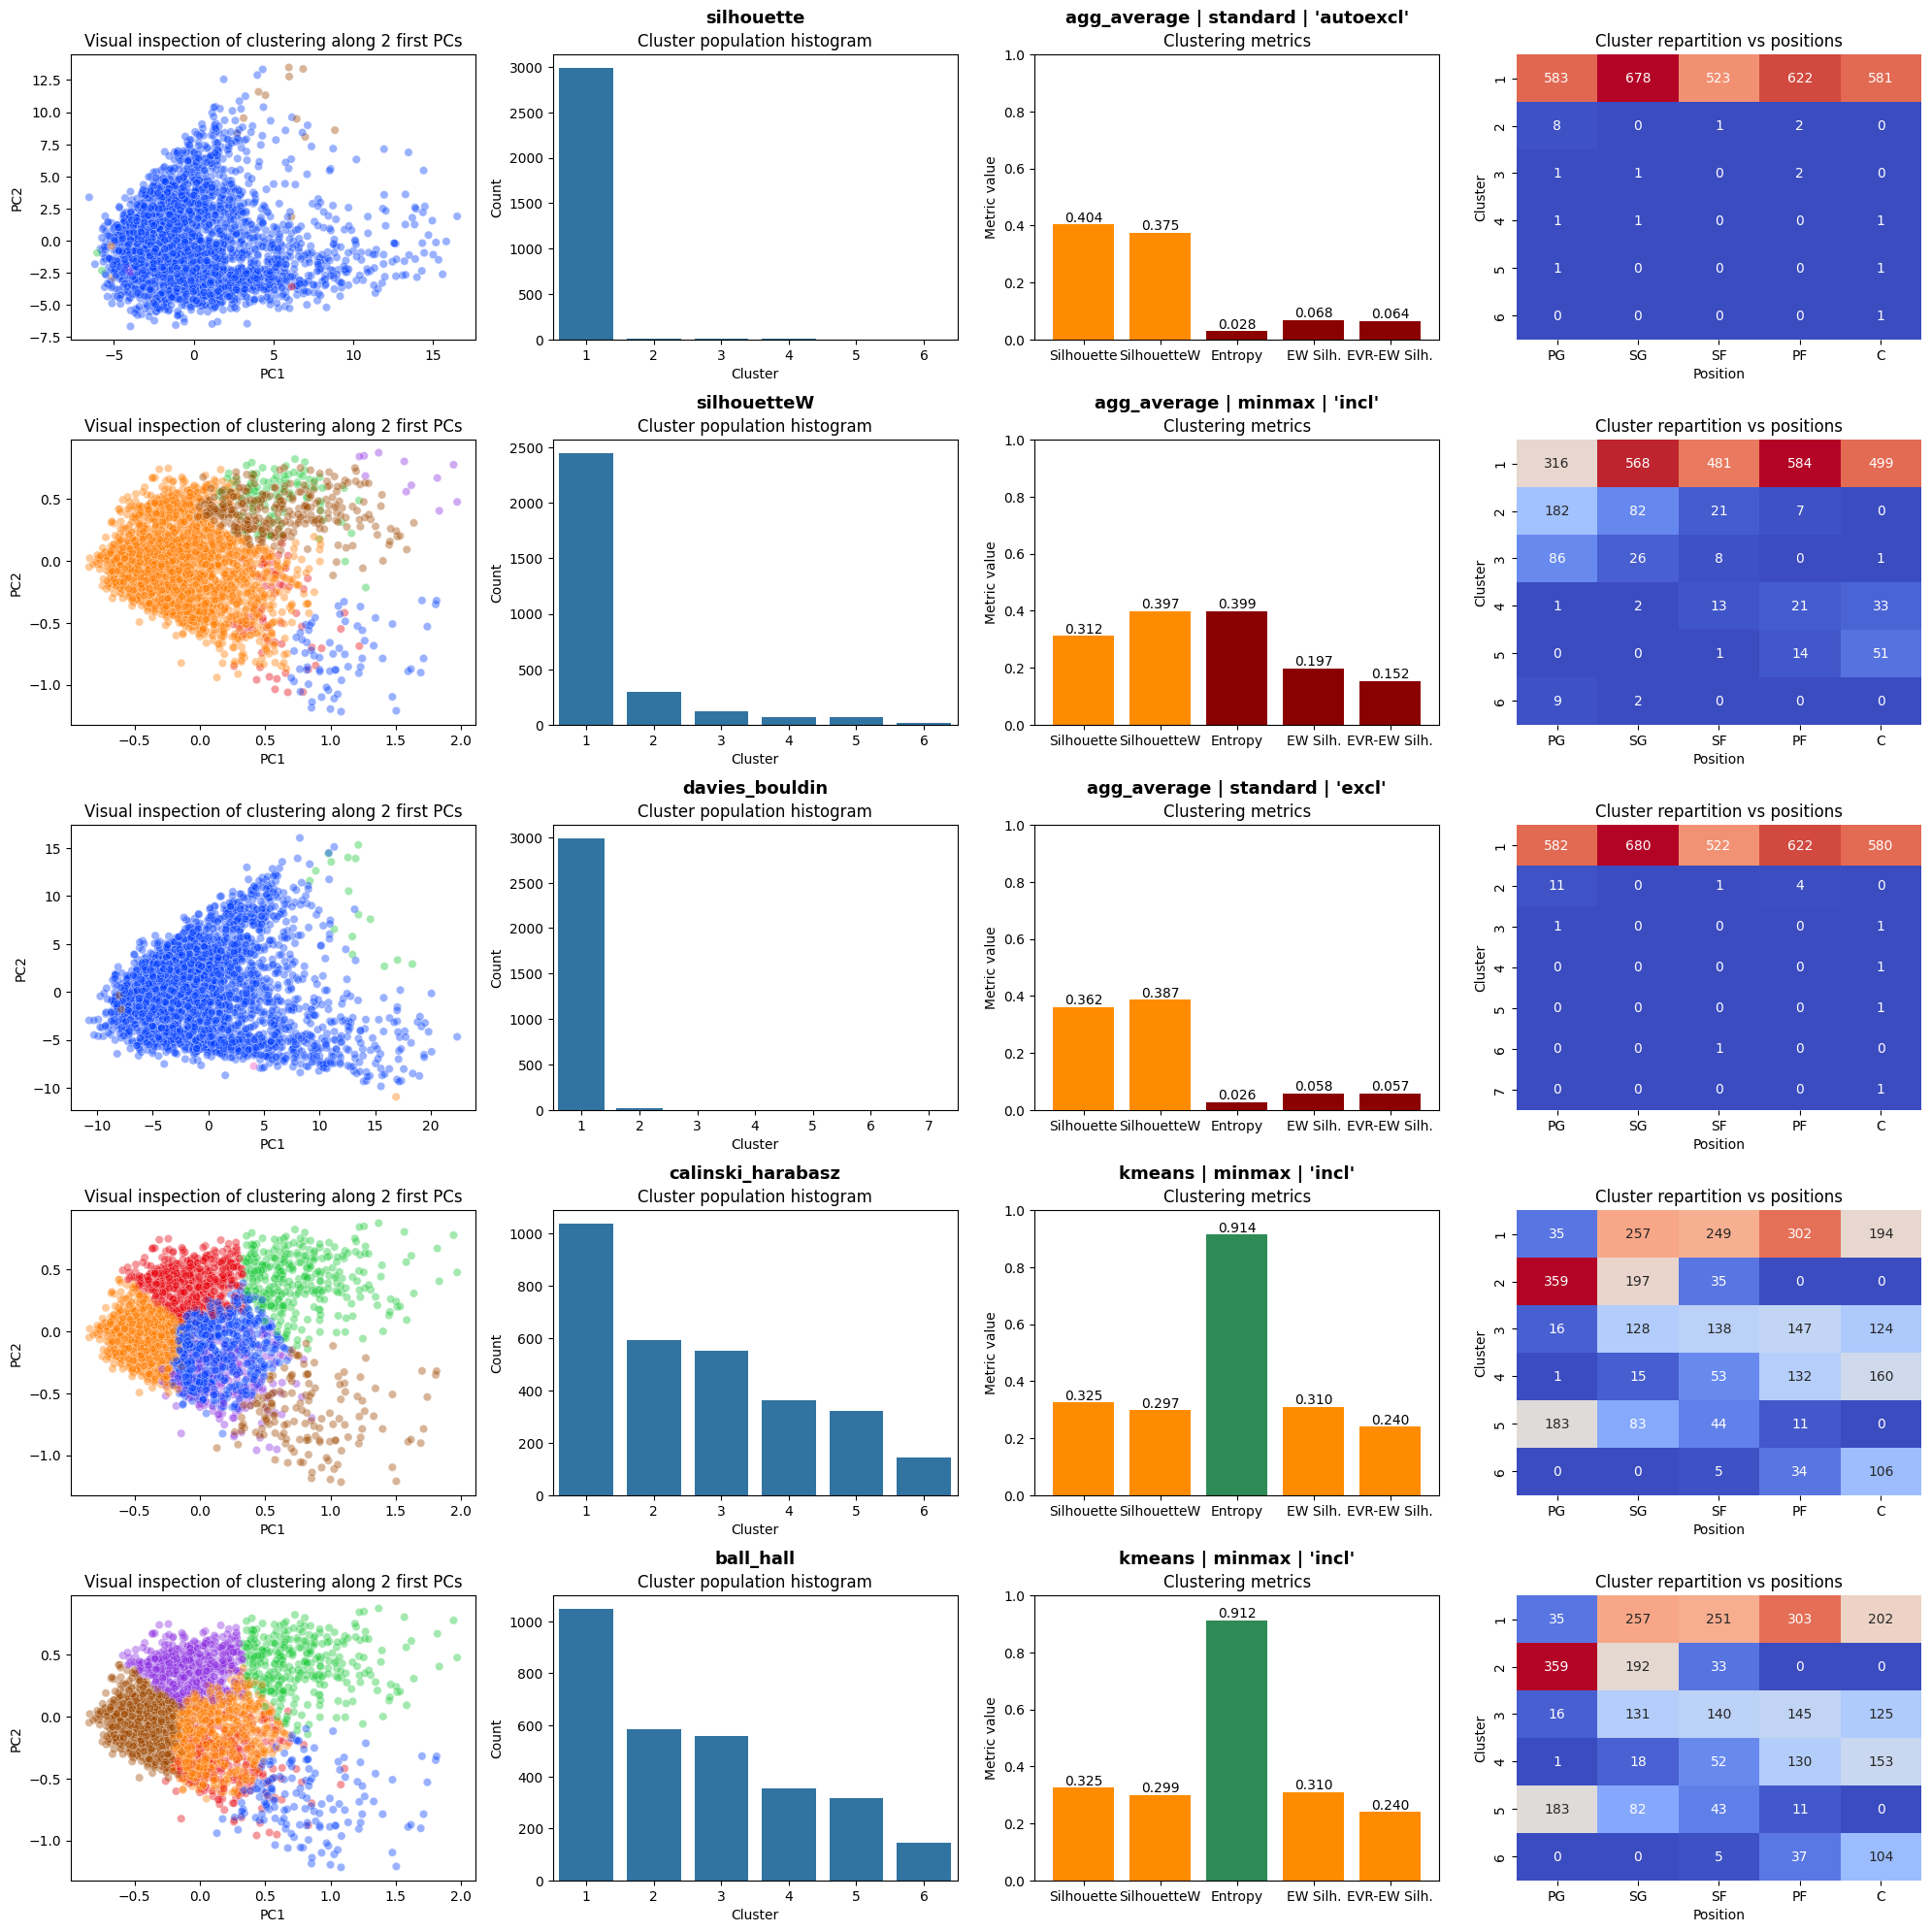

In [ ]:
n_methods = len([k for k,v in top_clusterings.items() if v['n_PC'] > 1])
fig, axs = plt.subplots(n_methods,4, figsize = (20,4 * n_methods));
i = 0
annot_kws = {'xy': (0.5, 1.05), 'xytext':(0, 10), 'xycoords':'axes fraction', 'textcoords':'offset points', 'ha':'center', 'va':'bottom', 'fontsize':13, 'fontweight':'bold', 'clip_on':False}
for metric in clusterer.metrics.keys() :
    item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
    n_PC = top_clusterings[metric]['n_PC']
    if not n_PC == 1 :
        clusterer.plot_clustering(**item, axs =( axs[i,0], axs[i,1], axs[i,2], axs[i,3]))
        axs[i,1].annotate(f"{metric}", **annot_kws)   
        axs[i,2].annotate(f"{item['method']} | {item['scaling']} | '{item['feature_selection']}'", **annot_kws)
        i+=1
    else :
        print(f"{metric} : Required {n_PC} PC to reach EVR of {item['evr']}")
plt.tight_layout() 
plt.show() 

In [10]:
metric = 'calinski_harabasz'
item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
print(item['method'], item['scaling'], item['feature_selection'])
X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


kmeans minmax incl
Silhouette: 0.297 | SilhouetteW: 0.277 | Davies-Bouldin: 1.098 | Calinski-Harabasz: 1239.376 | Ball-Hall: 0.971 | Normalized Entropy : 0.892


### <span style = 'color:pink'> Analysis

In [11]:
target_silhouette = 0.3
target_entropy = 0.3
target_evr = 0.6
target_n_clust = 6

target_df = cdf[(cdf['silhouette'] >= target_silhouette)&(cdf['entropy'] >= target_entropy)&(cdf['evr'] >= target_evr)&(cdf['n_clust'] >= target_n_clust)].sort_values(metric, ascending=False)
print(f"n° of experiments corresponding the the specified results : {target_df.shape[0]}")
target_df.head()

n° of experiments corresponding the the specified results : 38


feature_selection  method scaling  evr  n_PC  n_clust  silhouette  \
279              incl  kmeans  minmax  0.6     3        6    0.391048   
285              incl  kmeans  minmax  0.6     3       12    0.344744   
284              incl  kmeans  minmax  0.6     3       11    0.348909   
280              incl  kmeans  minmax  0.6     3        7    0.371782   
281              incl  kmeans  minmax  0.6     3        8    0.369507   

     silhouetteW  davies_bouldin  calinski_harabasz  ball_hall   entropy  \
279     0.380808        0.865633        2012.778978   1.797233  0.955323   
285     0.345833        0.885064        2010.706359   1.937972  0.977034   
284     0.352014        0.865731        1987.200187   1.905284  0.970329   
280     0.367145        0.898343        1977.531614   1.841945  0.953374   
281     0.363987        0.860684        1950.859535   1.848577  0.951610   

     e_w_silhouette  evr_e_w_silhouette  
279        0.382213            0.296061  
285        0.340762            0.263953  
284        0.343693            0.266224  
280        0.363011            0.281187  
281        0.360456            0.279208

Silhouette: 0.325 | SilhouetteW: 0.299 | Davies-Bouldin: 0.959 | Calinski-Harabasz: 1385.370 | Ball-Hall: 0.934 | Normalized Entropy : 0.913


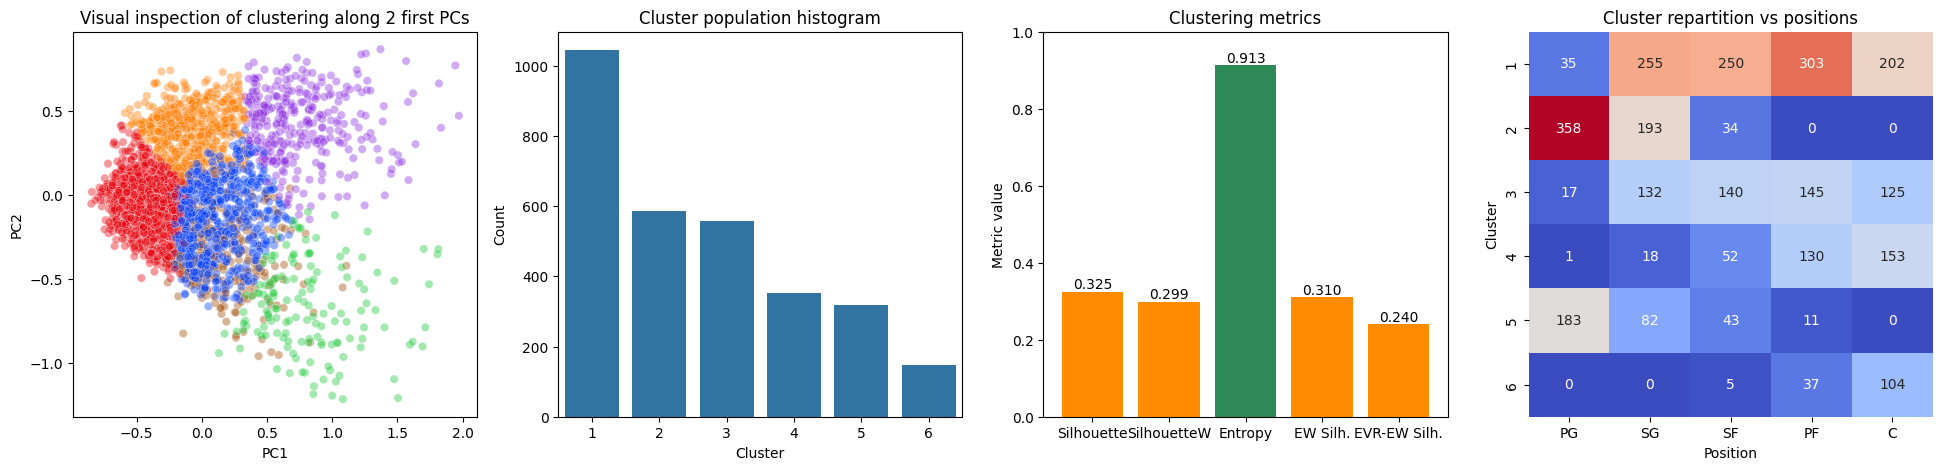

In [12]:
if target_df.shape[0] >0 :
    index = 0
    item = target_df.iloc[index][['feature_selection','method','scaling','evr','n_clust']]
    X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


In [13]:
cluster_df = clusterer.colinearity_handler.df.copy()
cluster_df['id'] = [int(x.split('_')[0]) for x in cluster_df.index]
cluster_df['name'] = cluster_df['id'].map(pid2name)
cluster_df['position'] = cluster_df.index.map(pid2pos_bref)
cluster_df['season'] = [x.split('_')[1] for x in cluster_df.index]
cluster_df['cluster'] = labels
cluster_df['cluster'] = cluster_df['cluster'].map( (cluster_df['cluster'].value_counts() + cluster_df['cluster'].value_counts().index / 1000 ).rank(ascending=False)).astype(int)

In [14]:
SMALL_CLUSTER_LIMIT = 8
small_clusters = list(cluster_df['cluster'].value_counts()[cluster_df['cluster'].value_counts()<SMALL_CLUSTER_LIMIT].index)
# cluster_df['cluster'].value_counts()

In [15]:
cluster_df[cluster_df['cluster'].isin(small_clusters)][['name','position','season','cluster']].sort_values('cluster')

Empty DataFrame
Columns: [name, position, season, cluster]
Index: []

In [16]:
cluster_df[cluster_df['cluster']==1][['name','position','season','cluster']]

name position   season  cluster
pidSzn                                                      
203932_2014-15       Aaron Gordon       PF  2014-15        1
202329_2014-15    Al-Farouq Aminu       SF  2014-15        1
101187_2014-15      Alan Anderson       SG  2014-15        1
203945_2014-15          Alex Kirk        C  2014-15        1
203459_2014-15       Allen Crabbe       SG  2014-15        1
...                           ...      ...      ...      ...
201163_2019-20    Wilson Chandler       PF  2019-20        1
1629139_2019-20     Yuta Watanabe       SF  2019-20        1
1629668_2019-20  Zach Norvell Jr.       SG  2019-20        1
1629015_2019-20      Zhaire Smith       SF  2019-20        1
1629597_2019-20    Zylan Cheatham       PF  2019-20        1

[1045 rows x 4 columns]